In [1]:
import json
from graphqlclient import GraphQLClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import requests
from datetime import datetime, timedelta
from time import sleep
import math

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100

sns.set(style="darkgrid")

client = GraphQLClient('https://api.thegraph.com/subgraphs/name/aave/protocol')

In [2]:
query_template = '''
{
	liquidationCalls(
		orderBy: collateralAmount
		orderDirection: desc
		first: 1000
		skip: %d
		where: { collateralAmount_gt: 0 }
	) {
		id
		timestamp
		collateralAmount
		principalAmount
		liquidator
		collateralReserve {
			symbol
		}
		principalReserve {
			symbol
		}
		user {
			id
		}
	}
}
'''

more = True
skip = 0
combined_data = []

while more:
    query = query_template % skip
    result = client.execute(query)
    data = json.loads(result)
    liq_calls = data["data"]["liquidationCalls"]
    combined_data += liq_calls
    skip += 1000
    if len(liq_calls) < 1000:
        more = False

print(len(combined_data))

1629


In [3]:
df = pd.io.json.json_normalize(combined_data)
df.head()

,collateralAmount,id,liquidator,principalAmount,timestamp,collateralReserve.symbol,principalReserve.symbol,user.id
0,9094563.020179,0x8e49050106d70b7ffbdf74477edc8195a45590051d53...,0x5d3183cb8967e3c9b605dc35081e5778ee462328,738430.191732751033578378,1596904356,USDC,LINK,0x108e4bfd9cda6243e1de53b71d08a0111974efc1
1,1535580.241273413614235997,0x6880deedd34228088d10ab6af1b0d8a54bf948d5daf2...,0xb00ba6778cf84100da676101e011b3d229458270,20129.933848,1584353366,LEND,USDC,0x40864c92b493566f75ed0606495e225dd73b9a31
2,941254.667059050727849426,0x515ce36d86a94a3cb575df28d9f14e8eac2218514cfe...,0x108a8b7200d044bbbe95bef6f671baec5473e05f,22356.52213312148370239,1597300693,ZRX,LINK,0x574ed0f2ebd15f566268d67f36dfe9c24a56e434
3,812007.099285,0xca4f53ce631297a7e549d309c48f017f6c7b4e115575...,0x228c1334fc57eb6e02ecc448e749a041124321c1,54550,1596993188,USDC,LINK,0x108e4bfd9cda6243e1de53b71d08a0111974efc1
4,787445.931296,0xbde5a4f21bd7af20dbe3fc067be66daf58baaaecd30b...,0x8cce0f304933a784026f85a14daadb0a33ab06cf,52900,1596993264,USDC,LINK,0xcf33d7b576d355070c72c6d8281f8e0f8ea28ac9


In [4]:
def roundup(x):
    return 100 + int(math.ceil(x / 100.0)) * 100

def roundup_higher(x):
    top = (10.0 ** 6)
    return top + int(math.ceil(x / top)) * top

def roundup_medium(x):
    top = (10.0 ** 3)*2
    return top + int(math.ceil(x / top)) * top

In [5]:
# Unique number of liquidators & users
uniq_liq = df["liquidator"].nunique()
uniq_user = df["user.id"].nunique()

print(uniq_liq, uniq_user)

278 359


In [6]:
# Number of times liquidators = users
(df["liquidator"] == df["user.id"]).value_counts()

False    1628
True        1
dtype: int64

In [7]:
df.liquidator.value_counts().head()

0xb00ba6778cf84100da676101e011b3d229458270    173
0xd37c0a03b2062bc8e2eaa1ad97b5e5e3510c3d79    150
0xdf60dcbb3bfcf9b4cd6e12359b27b6740013bbb5    128
0x92e01f9d6400c9575b00c27dedd98bf0212b3a06     76
0x09e80bde912794fdbea1e5b68b0c37a346b73cfc     73
Name: liquidator, dtype: int64

In [8]:
df["user.id"].value_counts().head()

0xcf33d7b576d355070c72c6d8281f8e0f8ea28ac9    197
0x108e4bfd9cda6243e1de53b71d08a0111974efc1     73
0x79faeabcdd74c740df800eefa0b093a8a23bccfc     48
0x553cf828af4c044bba43f3e71e8f4083b8add9af     35
0x6d017de141c4dfd4e31e9f23086ff7725abaca65     23
Name: user.id, dtype: int64

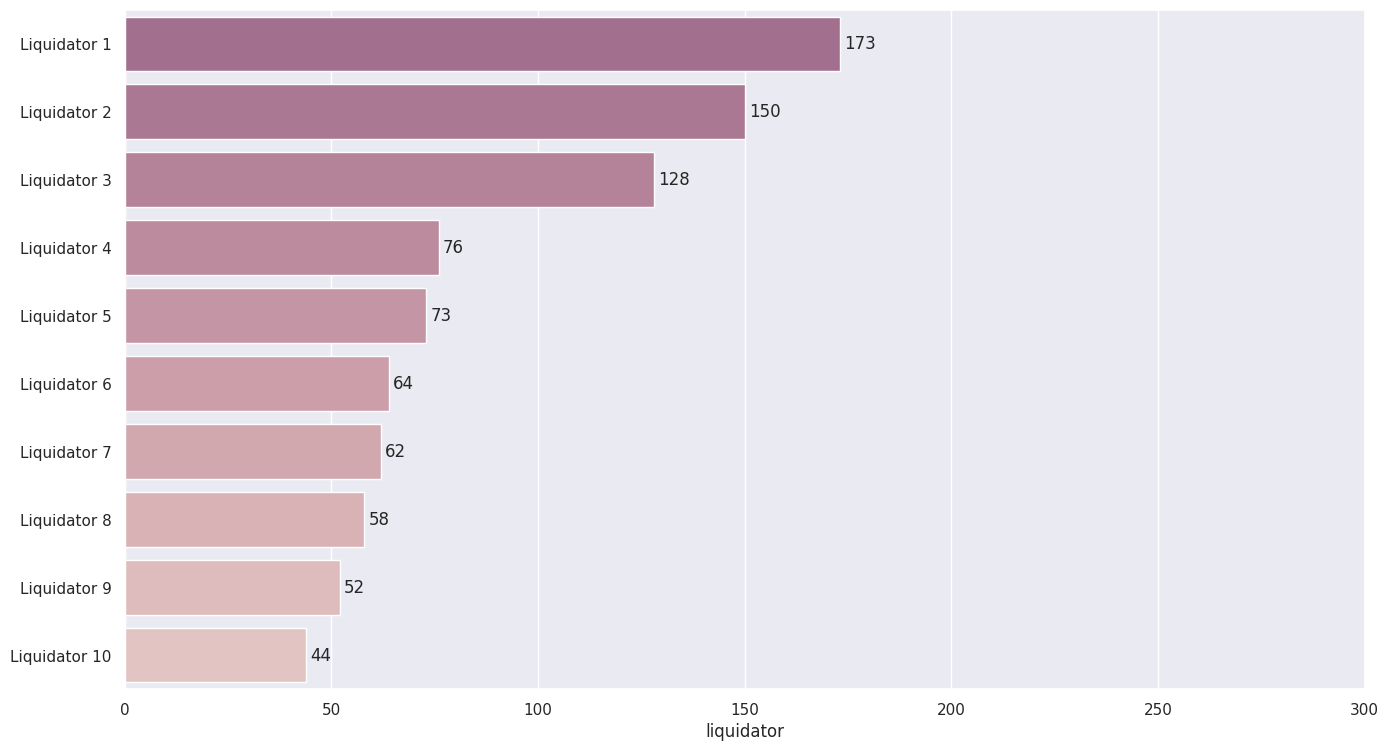

In [9]:
top_liq = df.liquidator.value_counts().nlargest(10)

liq_index = ["Liquidator " + str(x+1) for x in range(10)]

sns.set_palette(sns.cubehelix_palette(10, dark=0.5, light=0.8, reverse=True))
g = sns.barplot(y=liq_index, x=top_liq)

ax = g.axes

x_max = top_liq.max()
ax.set_xlim([0, roundup(x_max)])

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2, int(width), ha="left", va="center")
    
# ax.set(xlabel="Collateral Type", ylabel="Number of liquidations")

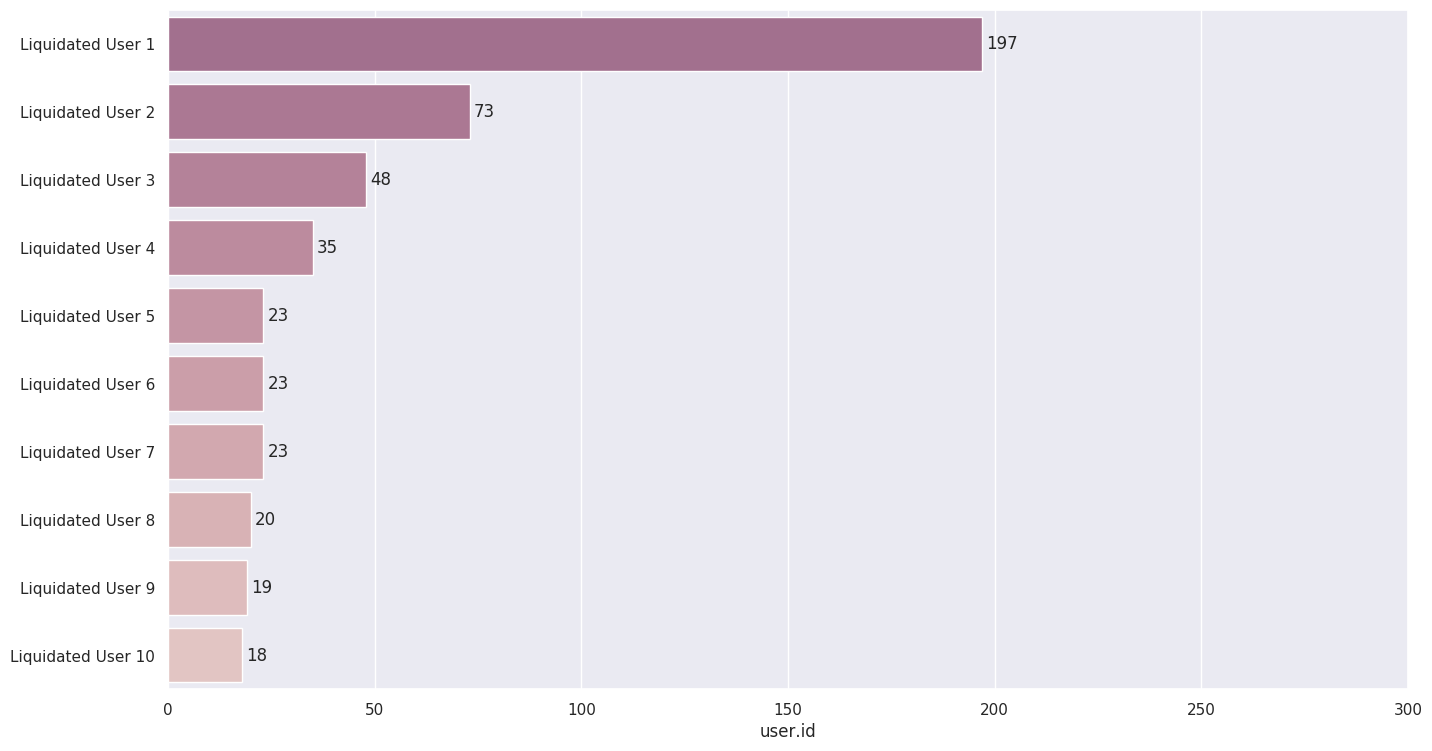

In [10]:
top_user = df["user.id"].value_counts().nlargest(10)

user_index = ["Liquidated User " + str(x+1) for x in range(10)]

sns.set_palette(sns.cubehelix_palette(10, dark=0.5, light=0.8, reverse=True))
g = sns.barplot(y=user_index, x=top_user)

ax = g.axes

x_max = top_liq.max()
ax.set_xlim([0, roundup(x_max)])

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2, int(width), ha="left", va="center")

In [11]:
coingecko_ids = {
    "LINK": "chainlink",
    "USDC": "usd-coin",
    "USDT": "tether",
    "TUSD": "true-usd",
    "ETH": "ethereum",
    "DAI": "dai",
    "BUSD": "binance-usd",
    "LEND": "ethlend",
    "SNX": "havven",
    "sUSD": "nusd",
    "WBTC": "wrapped-bitcoin",
    "KNC": "kyber-network",
    "REN": "republic-protocol",
    "MANA": "decentraland",
    "BAT": "basic-attention-token",
    "REP": "augur",
    "MKR": "maker",
    "ZRX": "0x"
}

In [12]:
prices = {}

if os.path.exists("prices.json"):
    with open("prices.json") as f:
        prices = json.load(f)
        print(len(prices))
else:
    for symbol in coingecko_ids:
        prices[coingecko_ids[symbol]] = {}

p_amount_usds = []
c_amount_usds = []

i = 0

for index, row in df.iterrows():
    if i % 10 == 0:
#         print("Iteration ", i)
        with open("prices.json", "w") as f:
            json.dump(prices, f)
    c_amount = float(row["collateralAmount"])
    p_amount = float(row["principalAmount"])
    c_symbol = coingecko_ids[row["collateralReserve.symbol"]]
    p_symbol = coingecko_ids[row["principalReserve.symbol"]]
    timestamp = row["timestamp"]
    t_object = datetime.fromtimestamp(timestamp)
    c_price = prices[c_symbol].get(str(timestamp), -1)
    p_price = prices[p_symbol].get(str(timestamp), -1)
    if c_price == -1:
        t_plus_six = datetime.timestamp(t_object + timedelta(hours=12))
        t_minus_six = datetime.timestamp(t_object - timedelta(hours=12))
        r_url = "https://api.coingecko.com/api/v3/coins/{}/market_chart/range?vs_currency=usd&from={}&to={}".format(c_symbol, t_minus_six, t_plus_six)
        r = requests.get(r_url)
        try:
            r_json = r.json()
        except:
            print(r_url)
        timestamps = [item[0] for item in r_json["prices"]]
        closest_timestamp = min(timestamps, key=lambda x:abs(x-timestamp))
        t_index = timestamps.index(closest_timestamp)
        c_price = r_json["prices"][t_index][1]
        prices[c_symbol][timestamp] = c_price
    if p_price == -1:
        t_plus_six = datetime.timestamp(t_object + timedelta(hours=12))
        t_minus_six = datetime.timestamp(t_object - timedelta(hours=12))
        r_url = "https://api.coingecko.com/api/v3/coins/{}/market_chart/range?vs_currency=usd&from={}&to={}".format(p_symbol, t_minus_six, t_plus_six)
        r = requests.get(r_url)
        r_json = r.json()
        timestamps = [item[0] for item in r_json["prices"]]
        closest_timestamp = min(timestamps, key=lambda x:abs(x-timestamp))
        t_index = timestamps.index(closest_timestamp)
        p_price = r_json["prices"][t_index][1]
        prices[p_symbol][timestamp] = p_price
    c_amount_usd = c_price * c_amount
    p_amount_usd = p_price * p_amount
    c_amount_usds.append(c_amount_usd)
    p_amount_usds.append(p_amount_usd)
    i += 1

with open("prices.json", "w") as f:
    json.dump(prices, f)
    
df["collateralAmountUsd"] = c_amount_usds
df["principalAmountUsd"] = p_amount_usds

18


In [13]:
df.head()

,collateralAmount,id,liquidator,principalAmount,timestamp,collateralReserve.symbol,principalReserve.symbol,user.id,collateralAmountUsd,principalAmountUsd
0,9094563.020179,0x8e49050106d70b7ffbdf74477edc8195a45590051d53...,0x5d3183cb8967e3c9b605dc35081e5778ee462328,738430.191732751033578378,1596904356,USDC,LINK,0x108e4bfd9cda6243e1de53b71d08a0111974efc1,9.075775e+06,7.759897e+06
1,1535580.241273413614235997,0x6880deedd34228088d10ab6af1b0d8a54bf948d5daf2...,0xb00ba6778cf84100da676101e011b3d229458270,20129.933848,1584353366,LEND,USDC,0x40864c92b493566f75ed0606495e225dd73b9a31,3.132844e+04,2.024152e+04
2,941254.667059050727849426,0x515ce36d86a94a3cb575df28d9f14e8eac2218514cfe...,0x108a8b7200d044bbbe95bef6f671baec5473e05f,22356.52213312148370239,1597300693,ZRX,LINK,0x574ed0f2ebd15f566268d67f36dfe9c24a56e434,4.300266e+05,3.426430e+05
3,812007.099285,0xca4f53ce631297a7e549d309c48f017f6c7b4e115575...,0x228c1334fc57eb6e02ecc448e749a041124321c1,54550,1596993188,USDC,LINK,0x108e4bfd9cda6243e1de53b71d08a0111974efc1,8.118336e+05,6.943323e+05
4,787445.931296,0xbde5a4f21bd7af20dbe3fc067be66daf58baaaecd30b...,0x8cce0f304933a784026f85a14daadb0a33ab06cf,52900,1596993264,USDC,LINK,0xcf33d7b576d355070c72c6d8281f8e0f8ea28ac9,7.872776e+05,6.733305e+05


In [14]:
df_index = df.index
df = df.sort_values("timestamp")
df.index = df_index
df.head()

,collateralAmount,id,liquidator,principalAmount,timestamp,collateralReserve.symbol,principalReserve.symbol,user.id,collateralAmountUsd,principalAmountUsd
0,3332.999163903649515379,0x2a67792cc34673e8c1ddc8e4a7f01497fae507201293...,0xd0ac3cabf268371bfcff1fb38a7736b962d7b03b,66,1578930691,LEND,sUSD,0xb880f5583f00d01f4b69d45172c11fad9d823d0d,80.173500,64.547415
1,59800,0xc5d014095edc1ab097d7d9d677f6788ff01420cd17e9...,0x30c2cc2a570378e2422fc75acd240978dfafbda9,52000,1579004635,LEND,LEND,0x5104efc872d45dba3a97bf02aebe240dfc283321,1349.141487,1173.166510
2,110.472890957217914931,0x08a1d5377764f8f40f584169a05ecc7a36c13a140620...,0x30c2cc2a570378e2422fc75acd240978dfafbda9,12.226623254994772065,1579041981,LEND,BAT,0xb92ca6002844ae39b90ec87b1867a7d85674dfeb,2.936553,2.347795
3,62.244026824116708606,0xfd687e173332fb10f3b20643e34ad2ae000c97392c44...,0x30c2cc2a570378e2422fc75acd240978dfafbda9,6.113313749780945611,1579049533,LEND,BAT,0xb92ca6002844ae39b90ec87b1867a7d85674dfeb,1.658735,1.164986
4,7.314551787004812431,0x705732e0d7c1fa6a8c8b7216fca9220d48944128c706...,0x30c2cc2a570378e2422fc75acd240978dfafbda9,29.22255349884475046,1579049861,DAI,ZRX,0xb15217fc398ed144ec91f258c8fcc5999ae7fede,7.289843,6.423558


In [15]:
# Total liquidated collateral reserve
print(df["collateralAmountUsd"].sum())

41470477.09306355


In [16]:
df["totalCollateralAmountUsd"] = df["collateralAmountUsd"].cumsum()
df.head()

,collateralAmount,id,liquidator,principalAmount,timestamp,collateralReserve.symbol,principalReserve.symbol,user.id,collateralAmountUsd,principalAmountUsd,totalCollateralAmountUsd
0,3332.999163903649515379,0x2a67792cc34673e8c1ddc8e4a7f01497fae507201293...,0xd0ac3cabf268371bfcff1fb38a7736b962d7b03b,66,1578930691,LEND,sUSD,0xb880f5583f00d01f4b69d45172c11fad9d823d0d,80.173500,64.547415,80.173500
1,59800,0xc5d014095edc1ab097d7d9d677f6788ff01420cd17e9...,0x30c2cc2a570378e2422fc75acd240978dfafbda9,52000,1579004635,LEND,LEND,0x5104efc872d45dba3a97bf02aebe240dfc283321,1349.141487,1173.166510,1429.314987
2,110.472890957217914931,0x08a1d5377764f8f40f584169a05ecc7a36c13a140620...,0x30c2cc2a570378e2422fc75acd240978dfafbda9,12.226623254994772065,1579041981,LEND,BAT,0xb92ca6002844ae39b90ec87b1867a7d85674dfeb,2.936553,2.347795,1432.251539
3,62.244026824116708606,0xfd687e173332fb10f3b20643e34ad2ae000c97392c44...,0x30c2cc2a570378e2422fc75acd240978dfafbda9,6.113313749780945611,1579049533,LEND,BAT,0xb92ca6002844ae39b90ec87b1867a7d85674dfeb,1.658735,1.164986,1433.910274
4,7.314551787004812431,0x705732e0d7c1fa6a8c8b7216fca9220d48944128c706...,0x30c2cc2a570378e2422fc75acd240978dfafbda9,29.22255349884475046,1579049861,DAI,ZRX,0xb15217fc398ed144ec91f258c8fcc5999ae7fede,7.289843,6.423558,1441.200117


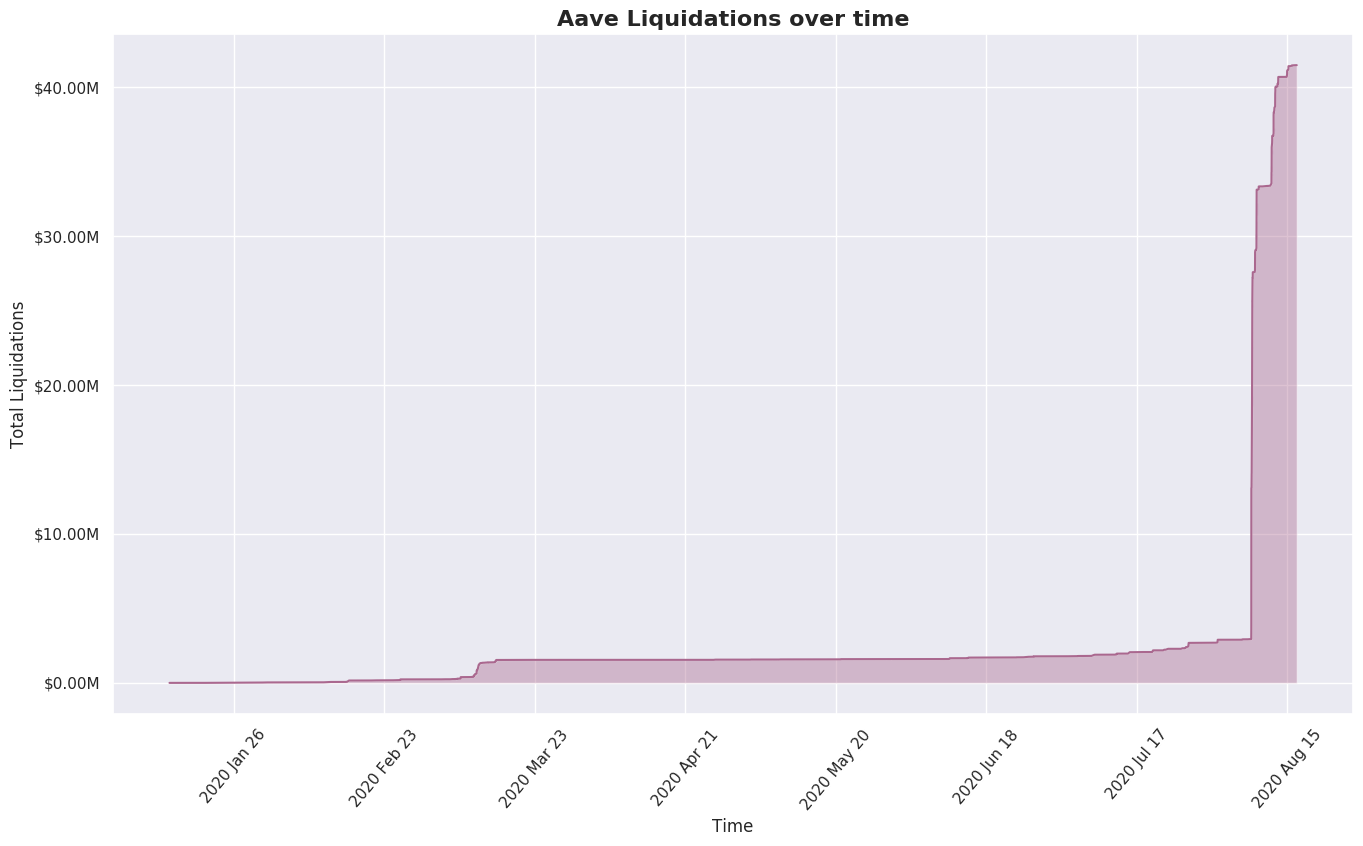

In [17]:
# df["datetime"] = pd.to_datetime(df["timestamp"], unit="s").dt.strftime("%Y-%b-%d\n %H:%M:%S")

lp = sns.lineplot(x="timestamp", y="totalCollateralAmountUsd", data=df)

ax = lp.axes
xticks = ax.get_xticks()
yticks = ax.get_yticks()

ax.set_xticklabels([pd.to_datetime(tm, unit="s").strftime("%Y %b %d") for tm in xticks], rotation=50)
ax.set_yticklabels(["${:,.2f}M".format(x) for x in yticks/(10**6)])

ax.set(xlabel="Time", ylabel="Total Liquidations")
ax.fill_between(df["timestamp"], 0, df["totalCollateralAmountUsd"], alpha=0.4)

plt.title("Aave Liquidations over time", fontweight="bold", fontsize=16)

plt.show()

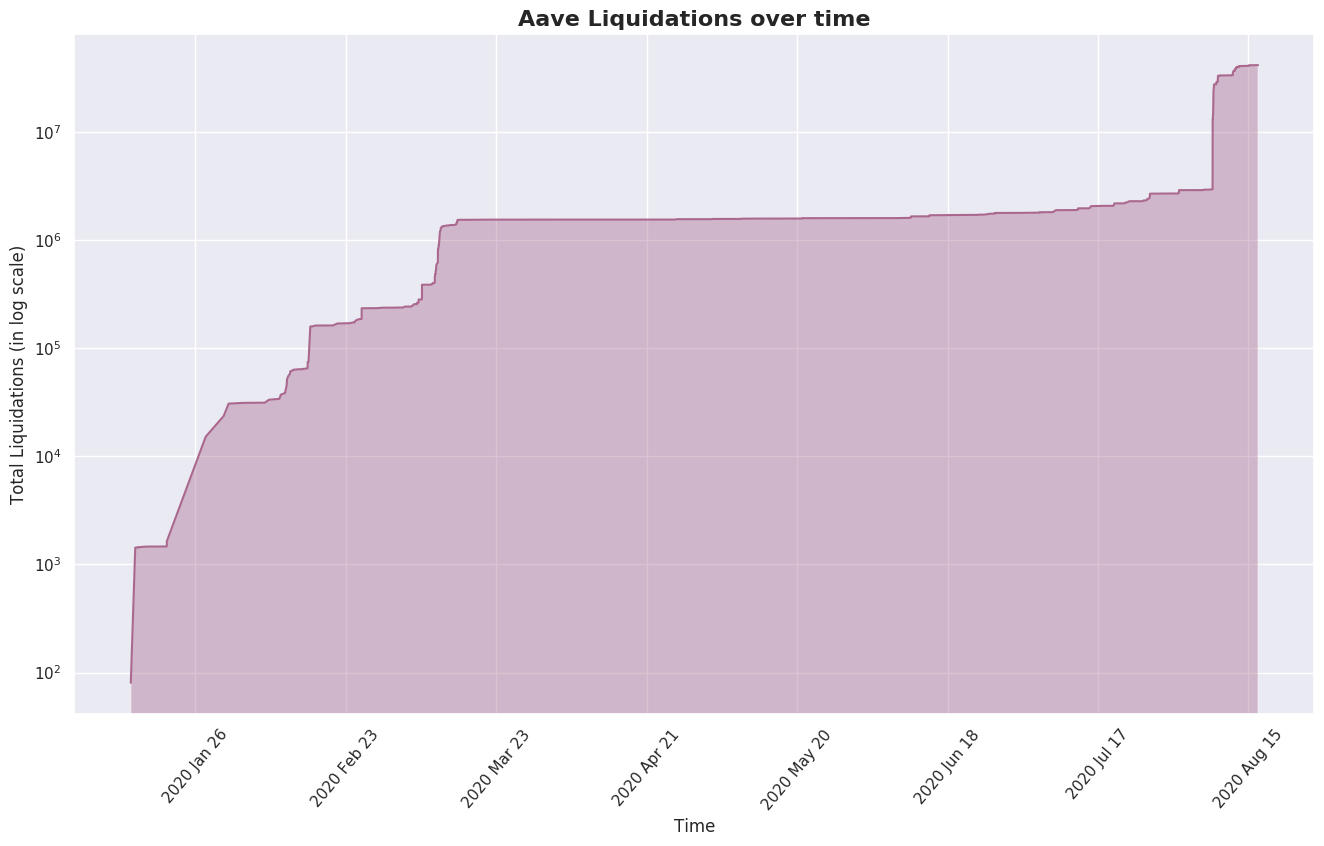

In [18]:
fig, ax = plt.subplots()

ax.set(yscale="log")

lp = sns.lineplot(x="timestamp", y="totalCollateralAmountUsd", data=df, ax=ax)

ax = lp.axes
xticks = ax.get_xticks()
yticks = ax.get_yticks()

ax.set_xticklabels([pd.to_datetime(tm, unit="s").strftime("%Y %b %d") for tm in xticks], rotation=50)
# ax.set_yticklabels(["${:,.2f}M".format(x) for x in yticks/(10**6)])

ax.set(xlabel="Time", ylabel="Total Liquidations (in log scale)")
ax.fill_between(df["timestamp"], 0, df["totalCollateralAmountUsd"], alpha=0.4)

plt.title("Aave Liquidations over time", fontweight="bold", fontsize=16)

plt.show()

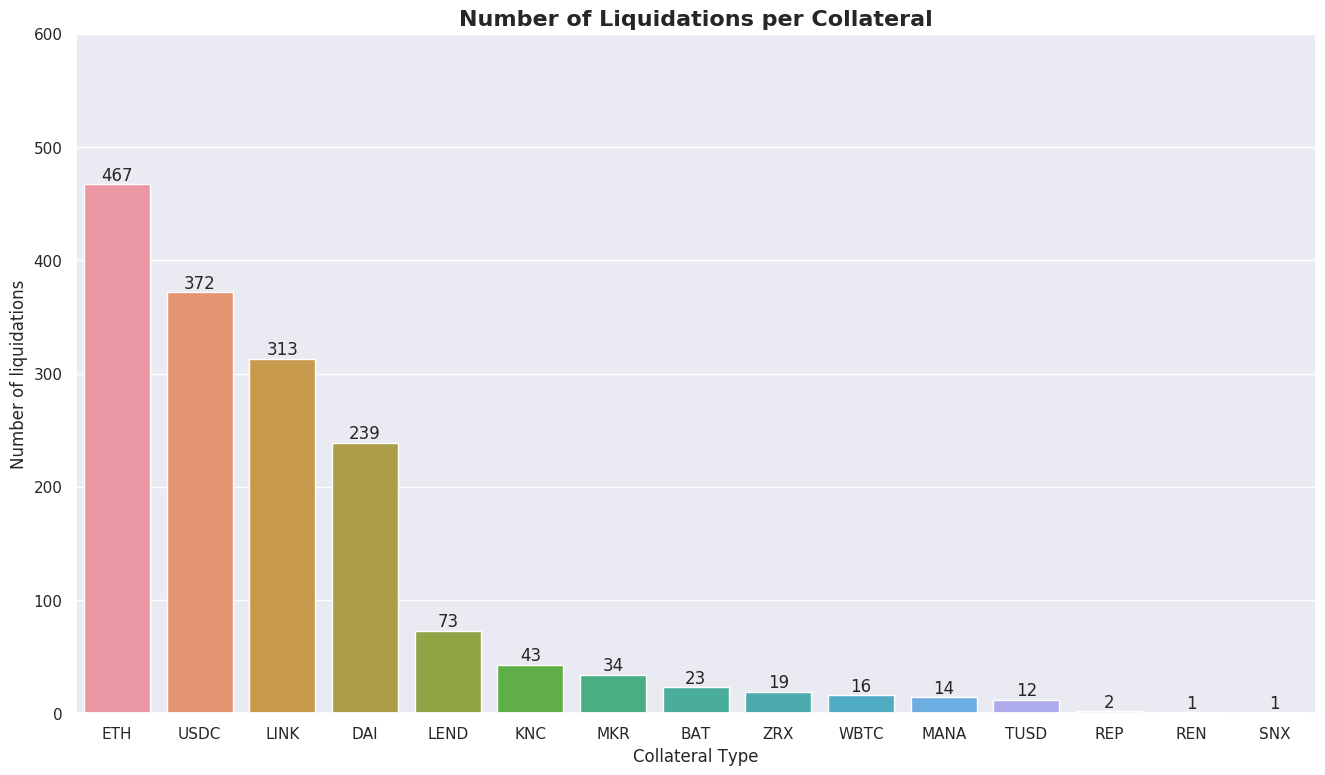

In [19]:
cp = sns.countplot("collateralReserve.symbol", data=df,
              order=df["collateralReserve.symbol"].value_counts().index)

ax = cp.axes

y_max = df["collateralReserve.symbol"].value_counts().max()
ax.set_ylim([0, roundup(y_max)])

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
           fontsize=12, ha='center', va='bottom')
    
ax.set(xlabel="Collateral Type", ylabel="Number of liquidations")

plt.title("Number of Liquidations per Collateral", fontweight="bold", fontsize=16)

plt.show()

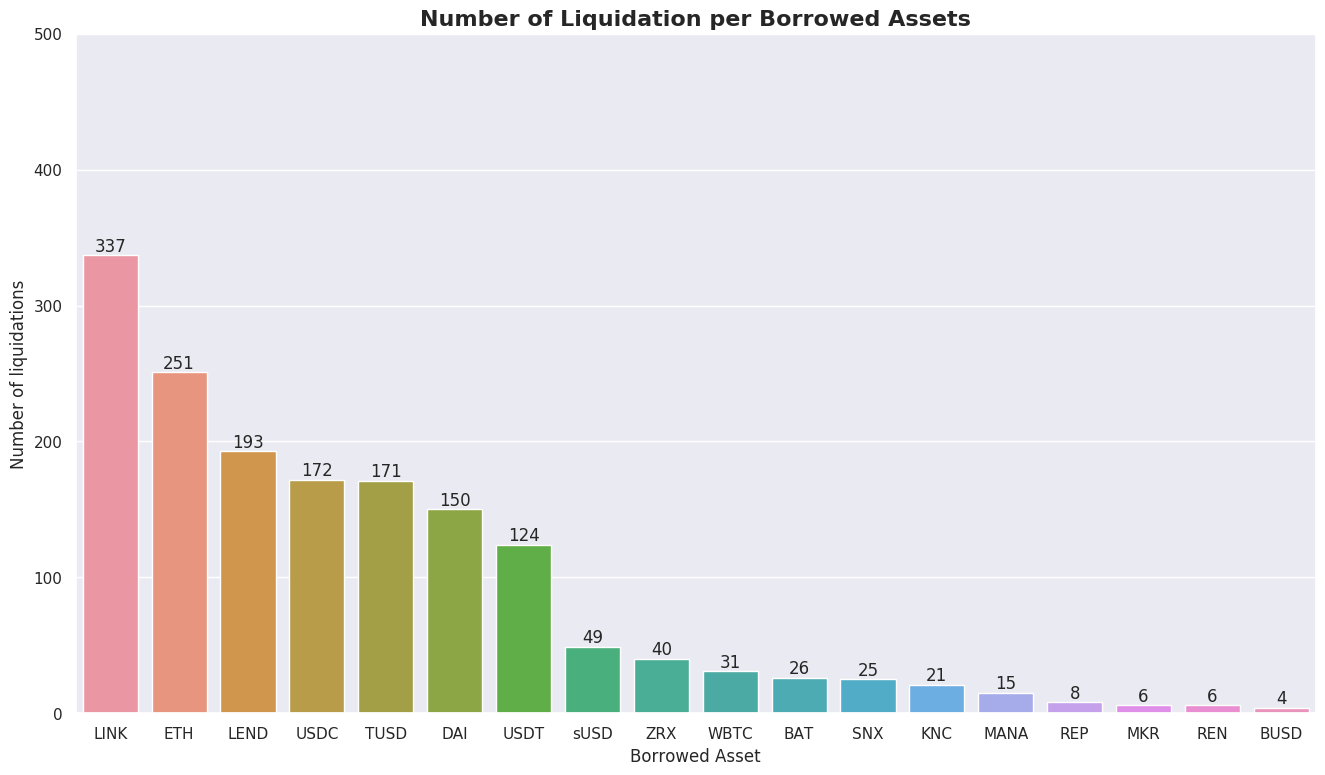

In [20]:
cp = sns.countplot("principalReserve.symbol", data=df,
              order=df["principalReserve.symbol"].value_counts().index)

ax = cp.axes

y_max = df["principalReserve.symbol"].value_counts().max()
ax.set_ylim([0, roundup(y_max)])

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
           fontsize=12, ha='center', va='bottom')
    
ax.set(xlabel="Borrowed Asset", ylabel="Number of liquidations")

plt.title("Number of Liquidation per Borrowed Assets", fontweight="bold", fontsize=16)

plt.show()

In [21]:
df["assetPair"] = df["collateralReserve.symbol"] + "/" + df["principalReserve.symbol"]
df.head()

,collateralAmount,id,liquidator,principalAmount,timestamp,collateralReserve.symbol,principalReserve.symbol,user.id,collateralAmountUsd,principalAmountUsd,totalCollateralAmountUsd,assetPair
0,3332.999163903649515379,0x2a67792cc34673e8c1ddc8e4a7f01497fae507201293...,0xd0ac3cabf268371bfcff1fb38a7736b962d7b03b,66,1578930691,LEND,sUSD,0xb880f5583f00d01f4b69d45172c11fad9d823d0d,80.173500,64.547415,80.173500,LEND/sUSD
1,59800,0xc5d014095edc1ab097d7d9d677f6788ff01420cd17e9...,0x30c2cc2a570378e2422fc75acd240978dfafbda9,52000,1579004635,LEND,LEND,0x5104efc872d45dba3a97bf02aebe240dfc283321,1349.141487,1173.166510,1429.314987,LEND/LEND
2,110.472890957217914931,0x08a1d5377764f8f40f584169a05ecc7a36c13a140620...,0x30c2cc2a570378e2422fc75acd240978dfafbda9,12.226623254994772065,1579041981,LEND,BAT,0xb92ca6002844ae39b90ec87b1867a7d85674dfeb,2.936553,2.347795,1432.251539,LEND/BAT
3,62.244026824116708606,0xfd687e173332fb10f3b20643e34ad2ae000c97392c44...,0x30c2cc2a570378e2422fc75acd240978dfafbda9,6.113313749780945611,1579049533,LEND,BAT,0xb92ca6002844ae39b90ec87b1867a7d85674dfeb,1.658735,1.164986,1433.910274,LEND/BAT
4,7.314551787004812431,0x705732e0d7c1fa6a8c8b7216fca9220d48944128c706...,0x30c2cc2a570378e2422fc75acd240978dfafbda9,29.22255349884475046,1579049861,DAI,ZRX,0xb15217fc398ed144ec91f258c8fcc5999ae7fede,7.289843,6.423558,1441.200117,DAI/ZRX


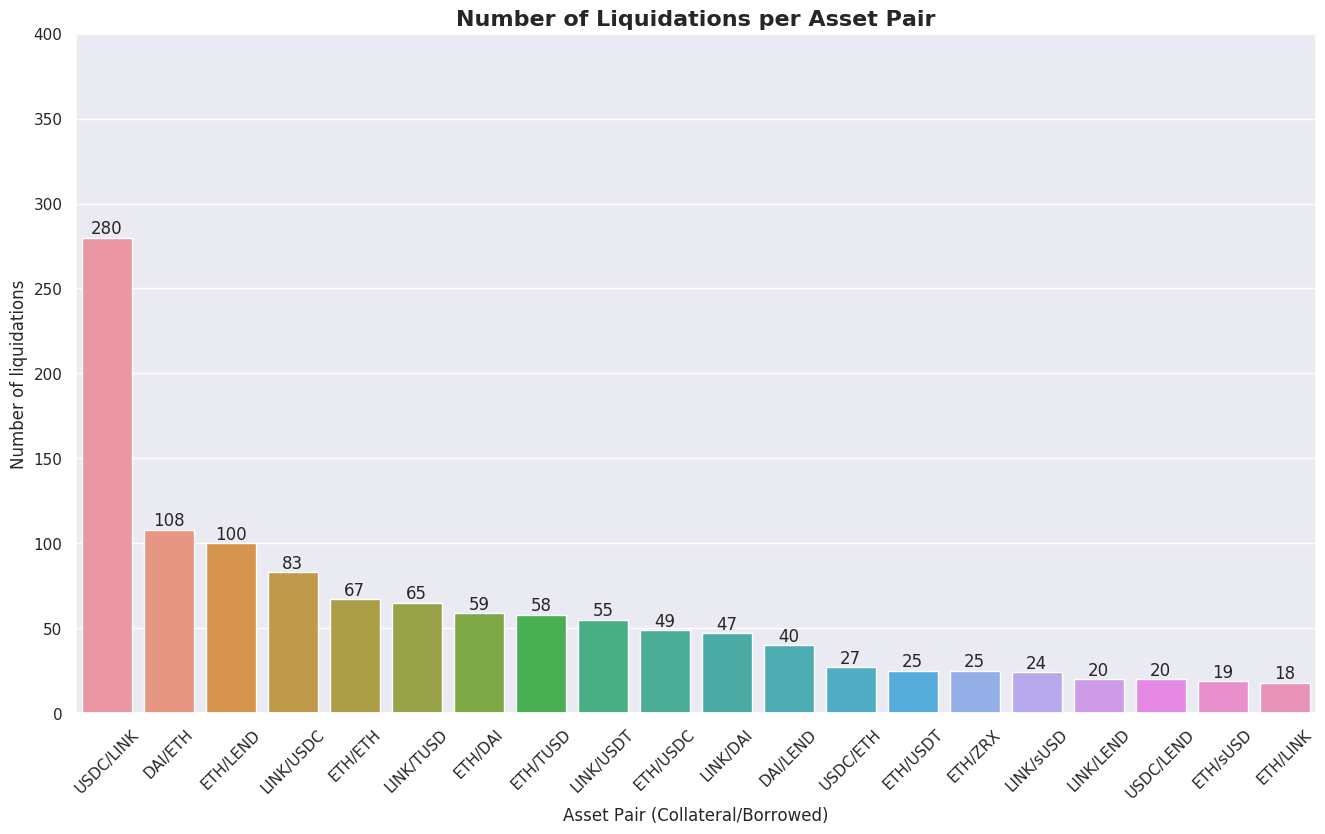

In [22]:
cp = sns.countplot("assetPair", data=df,
              order=df["assetPair"].value_counts().iloc[:20].index)

ax = cp.axes

y_max = df["assetPair"].value_counts().max()
ax.set_ylim([0, roundup(y_max)])

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
           fontsize=12, ha='center', va='bottom')
    
ax.set(xlabel="Asset Pair (Collateral/Borrowed)", ylabel="Number of liquidations")

plt.xticks(rotation=45)

plt.title("Number of Liquidations per Asset Pair", fontweight="bold", fontsize=16)

plt.show()

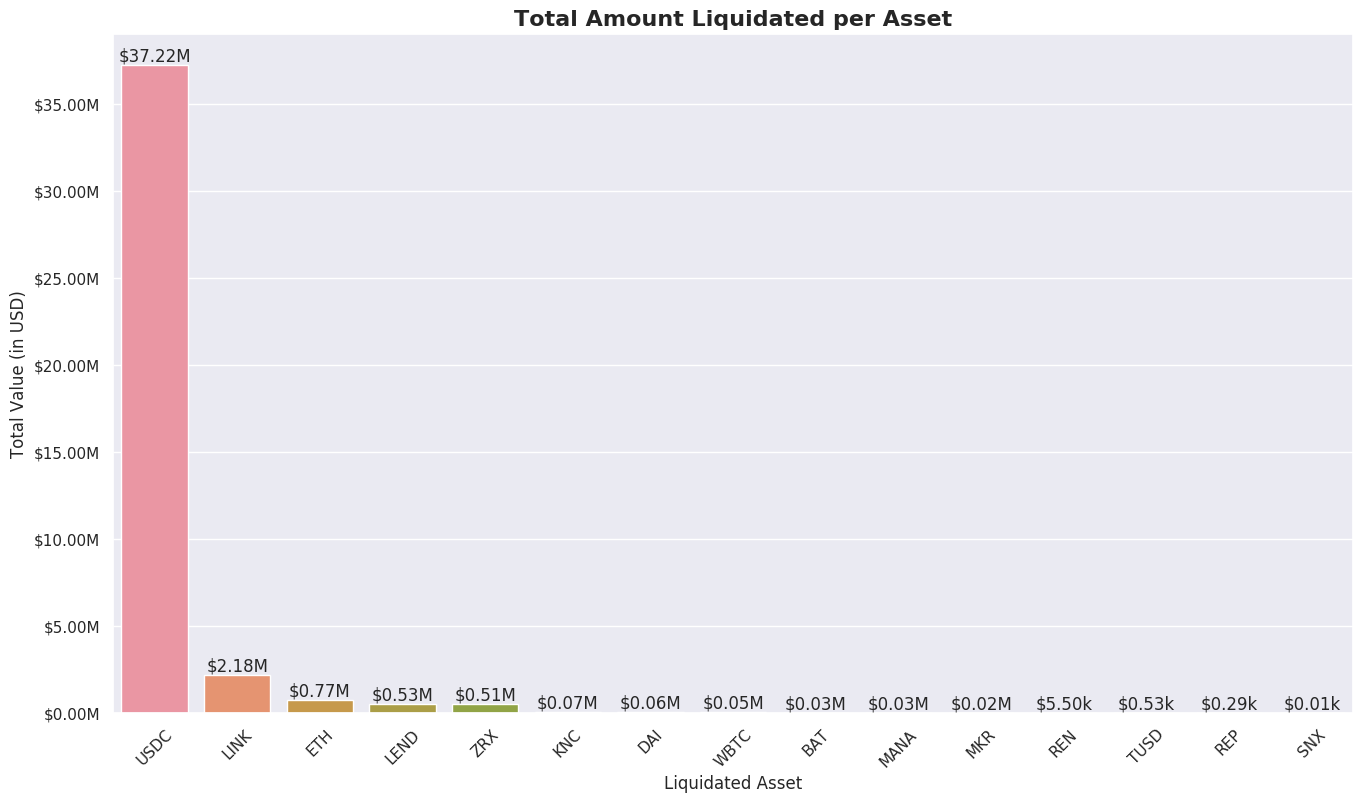

In [23]:
total_liq = df.groupby("collateralReserve.symbol")["collateralAmountUsd"].sum().to_frame().reset_index()

total_liq = total_liq.sort_values("collateralAmountUsd", ascending=False)

cp = sns.barplot(x="collateralReserve.symbol", y="collateralAmountUsd", data=total_liq)

ax = cp.axes

yticks = ax.get_yticks()
ax.set_yticklabels(["${:,.2f}M".format(x) for x in yticks/(10**6)])

y_max = total_liq["collateralAmountUsd"].max()
ax.set_ylim([0, roundup_higher(y_max)])

def get_label(y):
    if y <= 10 ** 4:
        return "${:,.2f}k".format(y / (10**3))
    return "${:,.2f}M".format(p.get_height() / (10**6))

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), get_label(p.get_height()),
           fontsize=12, ha='center', va='bottom')
    
ax.set(xlabel="Liquidated Asset", ylabel="Total Value (in USD)")

plt.xticks(rotation=45)

plt.title("Total Amount Liquidated per Asset", fontweight="bold", fontsize=16)

plt.show()

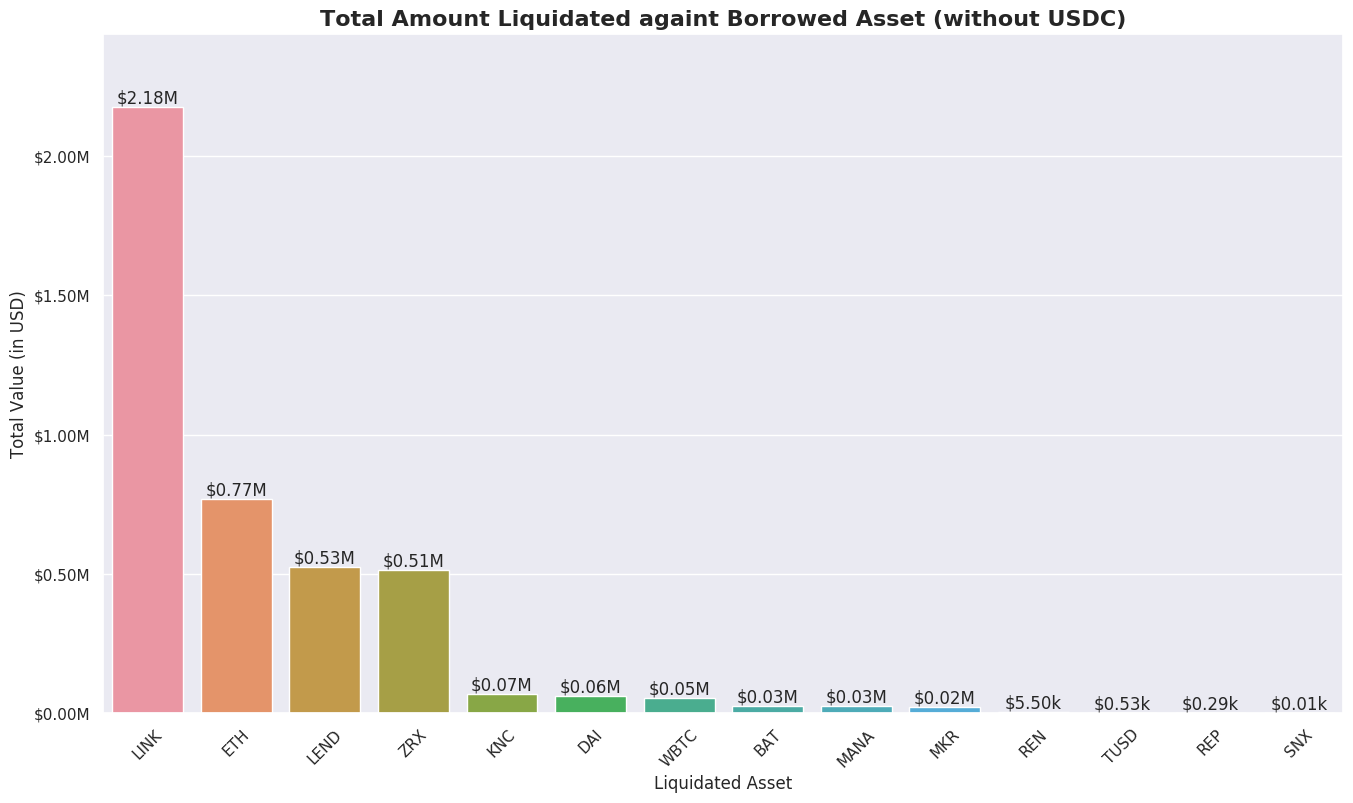

In [24]:
total_liq = df.groupby("collateralReserve.symbol")["collateralAmountUsd"].sum().to_frame().reset_index()

total_liq = total_liq.sort_values("collateralAmountUsd", ascending=False)

cp = sns.barplot(x="collateralReserve.symbol", y="collateralAmountUsd", data=total_liq,
                order=total_liq["collateralReserve.symbol"].iloc[1:].values)

ax = cp.axes

yticks = ax.get_yticks()
ax.set_yticklabels(["${:,.2f}M".format(x) for x in yticks/(10**6)])

y_max = total_liq["collateralAmountUsd"].max()
ax.set_ylim([0, roundup_higher(y_max) / 16])

def get_label(y):
    if y <= 10 ** 4:
        return "${:,.2f}k".format(y / (10**3))
    return "${:,.2f}M".format(p.get_height() / (10**6))

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), get_label(p.get_height()),
           fontsize=12, ha='center', va='bottom')
    
ax.set(xlabel="Liquidated Asset", ylabel="Total Value (in USD)")

plt.xticks(rotation=45)

plt.title("Total Amount Liquidated againt Borrowed Asset (without USDC)", fontweight="bold", fontsize=16)

plt.show()

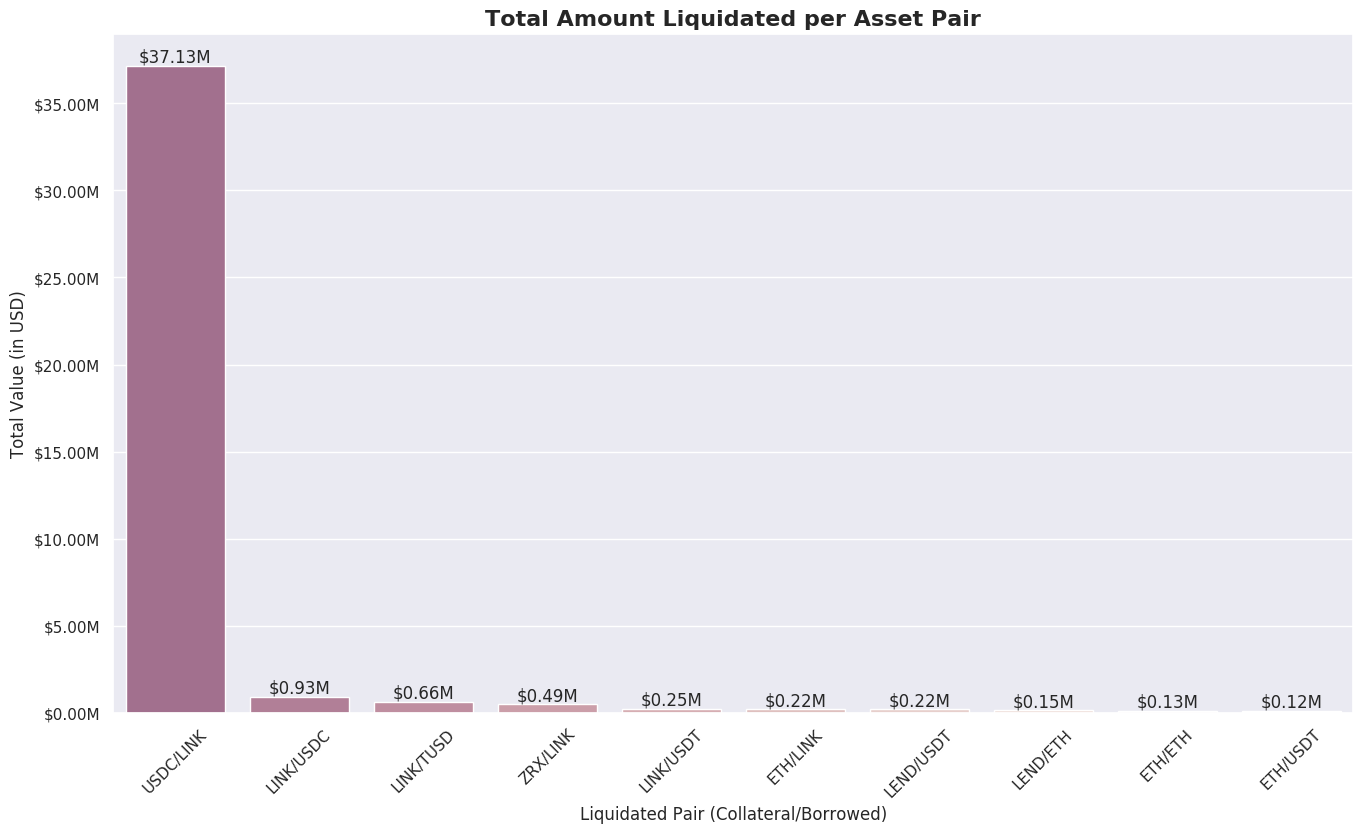

In [25]:
total_liq = df.groupby("assetPair")["collateralAmountUsd"].sum().to_frame().sort_values("collateralAmountUsd", ascending=False).reset_index()

sns.set_palette(sns.cubehelix_palette(10, dark=0.5, light=1, reverse=True))
cp = sns.barplot(x="assetPair", y="collateralAmountUsd", data=total_liq,
                 order=total_liq["assetPair"].iloc[:10].values)

ax = cp.axes

yticks = ax.get_yticks()
ax.set_yticklabels(["${:,.2f}M".format(x) for x in yticks/(10**6)])

y_max = total_liq["collateralAmountUsd"].max()
ax.set_ylim([0, roundup_higher(y_max)])

def get_label(y):
    if y <= 10 ** 4:
        return "${:,.2f}k".format(y / (10**3))
    return "${:,.2f}M".format(p.get_height() / (10**6))

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), get_label(p.get_height()),
           fontsize=12, ha='center', va='bottom')
    
ax.set(xlabel="Liquidated Pair (Collateral/Borrowed)", ylabel="Total Value (in USD)")

plt.xticks(rotation=45)

plt.title("Total Amount Liquidated per Asset Pair", fontweight="bold", fontsize=16)

plt.show()

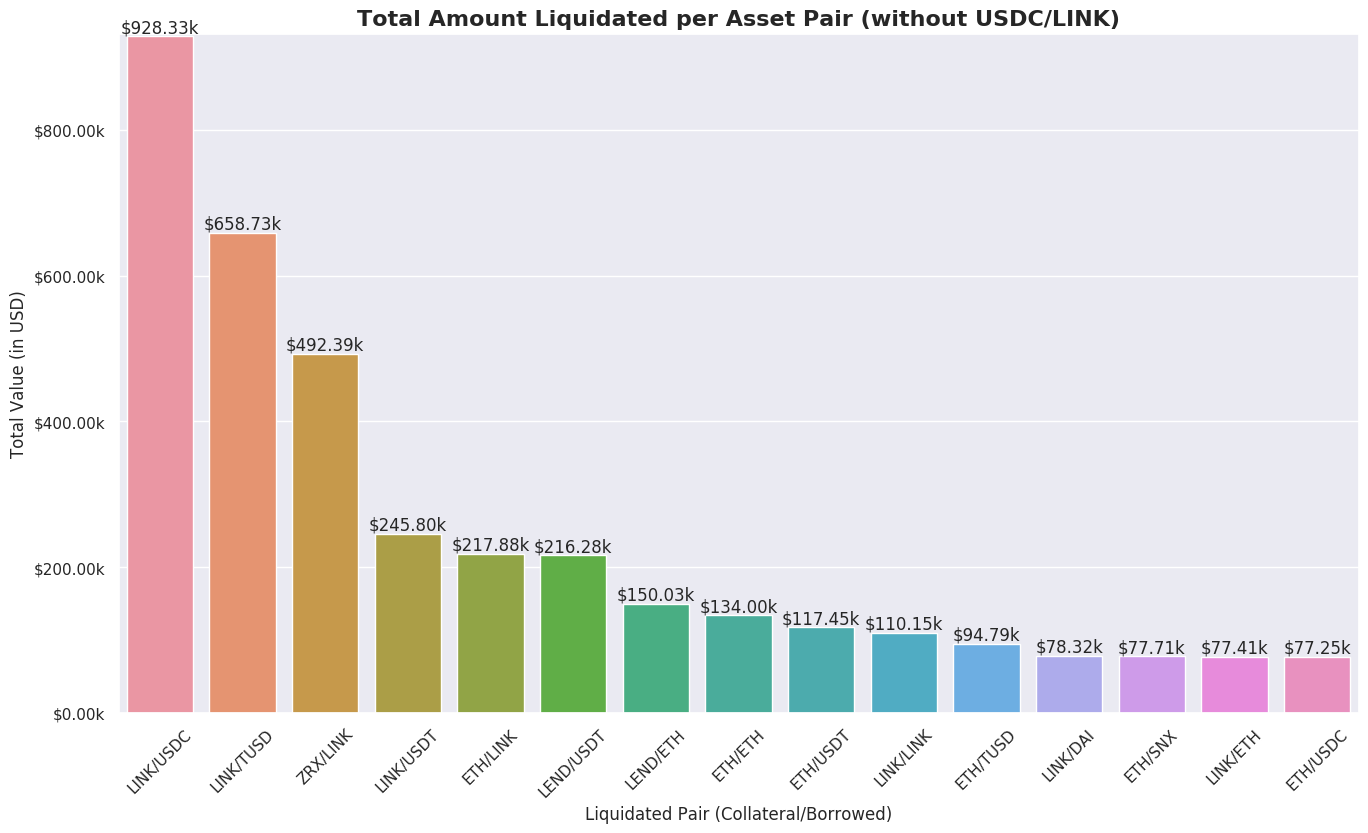

In [26]:
total_liq = df.groupby("assetPair")["collateralAmountUsd"].sum().to_frame().sort_values("collateralAmountUsd", ascending=False).reset_index()

cp = sns.barplot(x="assetPair", y="collateralAmountUsd", data=total_liq,
                 order=total_liq["assetPair"].iloc[1:16].values)

ax = cp.axes

yticks = ax.get_yticks()
ax.set_yticklabels(["${:,.2f}k".format(x) for x in yticks/(10**3)])

y_max = total_liq["collateralAmountUsd"].iloc[1:16].max()
ax.set_ylim([0, roundup_medium(y_max)])

def get_label(y):
    return "${:,.2f}k".format(y / (10**3))

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), get_label(p.get_height()),
           fontsize=12, ha='center', va='bottom')
    
ax.set(xlabel="Liquidated Pair (Collateral/Borrowed)", ylabel="Total Value (in USD)")

plt.xticks(rotation=45)

plt.title("Total Amount Liquidated per Asset Pair (without USDC/LINK)", fontweight="bold", fontsize=16)

plt.show()

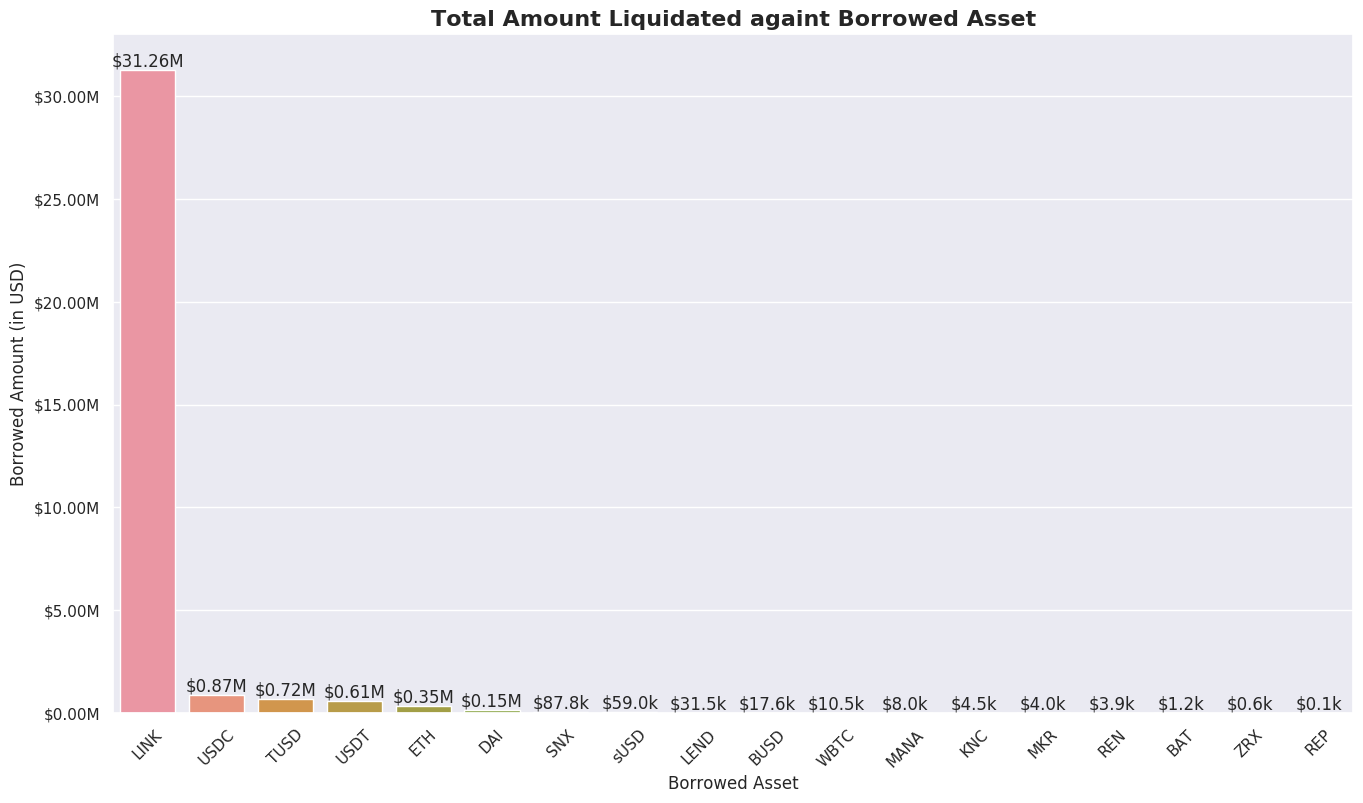

In [27]:
total_liq = df.groupby("principalReserve.symbol")["principalAmountUsd"].sum().to_frame().reset_index()

total_liq = total_liq.sort_values("principalAmountUsd", ascending=False)

cp = sns.barplot(x="principalReserve.symbol", y="principalAmountUsd", data=total_liq)

ax = cp.axes

yticks = ax.get_yticks()
ax.set_yticklabels(["${:,.2f}M".format(x) for x in yticks/(10**6)])

y_max = total_liq["principalAmountUsd"].max()
ax.set_ylim([0, roundup_higher(y_max)])

def get_label(y):
    if y <= 10 ** 5:
        return "${:,.1f}k".format(y / (10**3))
    return "${:,.2f}M".format(p.get_height() / (10**6))

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), get_label(p.get_height()),
           fontsize=12, ha='center', va='bottom')
    
ax.set(xlabel="Borrowed Asset", ylabel="Borrowed Amount (in USD)")

plt.xticks(rotation=45)

plt.title("Total Amount Liquidated againt Borrowed Asset", fontweight="bold", fontsize=16)

plt.show()

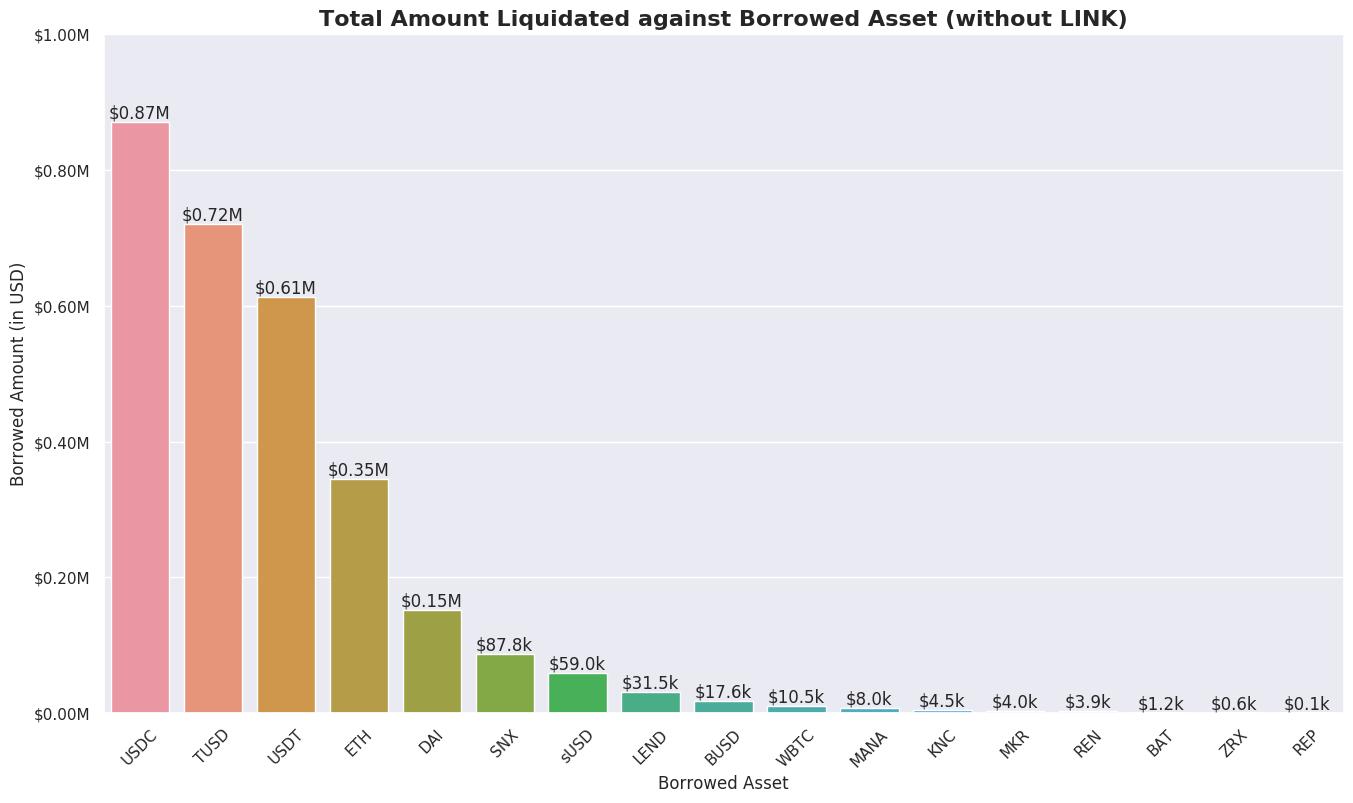

In [28]:
total_liq = df.groupby("principalReserve.symbol")["principalAmountUsd"].sum().to_frame().reset_index()

total_liq = total_liq.sort_values("principalAmountUsd", ascending=False)

cp = sns.barplot(x="principalReserve.symbol", y="principalAmountUsd", data=total_liq,
                order=total_liq["principalReserve.symbol"].iloc[1:].values)

ax = cp.axes

yticks = ax.get_yticks()
ax.set_yticklabels(["${:,.2f}M".format(x) for x in yticks/(10**6)])

y_max = total_liq["principalAmountUsd"].iloc[1:].max()
ax.set_ylim([0, roundup_higher(y_max) / 2])

def get_label(y):
    if y <= 10 ** 5:
        return "${:,.1f}k".format(y / (10**3))
    return "${:,.2f}M".format(p.get_height() / (10**6))

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), get_label(p.get_height()),
           fontsize=12, ha='center', va='bottom')
    
ax.set(xlabel="Borrowed Asset", ylabel="Borrowed Amount (in USD)")

plt.xticks(rotation=45)

plt.title("Total Amount Liquidated against Borrowed Asset (without LINK)", fontweight="bold", fontsize=16)

plt.show()

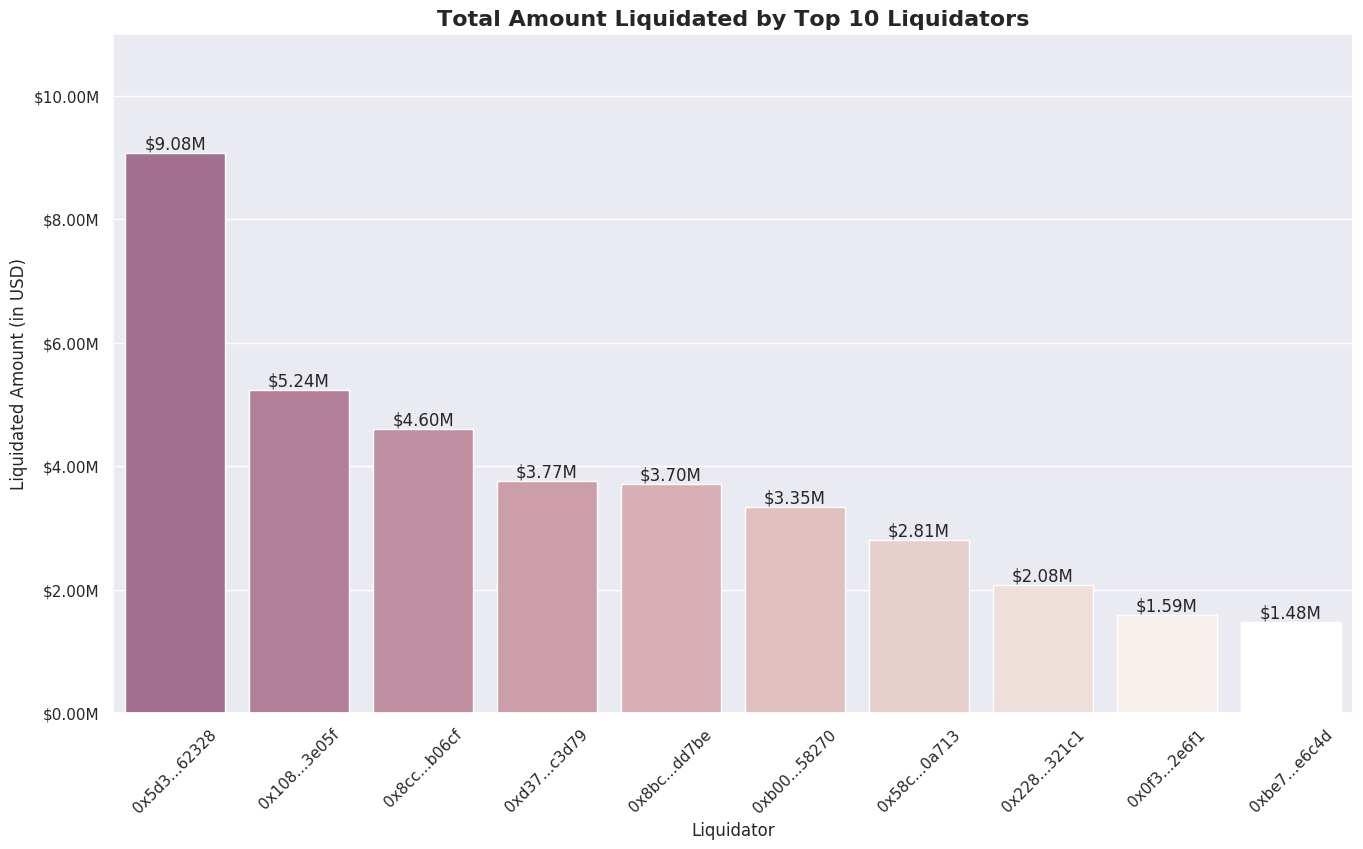

In [29]:
total_liq = df.groupby("liquidator")["collateralAmountUsd"].sum().to_frame().sort_values("collateralAmountUsd", ascending=False).iloc[:10].reset_index()

new_names = []

for index, row in total_liq.iterrows():
    new_names.append(row["liquidator"][:5] + "..." + row["liquidator"][-5:])
    
total_liq["liquidator"] = new_names

sns.set_palette(sns.cubehelix_palette(10, dark=0.5, light=1, reverse=True))
cp = sns.barplot(x="liquidator", y="collateralAmountUsd", data=total_liq)

ax = cp.axes

yticks = ax.get_yticks()
ax.set_yticklabels(["${:,.2f}M".format(x) for x in yticks/(10**6)])

y_max = total_liq["collateralAmountUsd"].max()
ax.set_ylim([0, roundup_higher(y_max)])

def get_label(y):
    if y <= 10 ** 5:
        return "${:,.1f}k".format(y / (10**3))
    return "${:,.2f}M".format(p.get_height() / (10**6))

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), get_label(p.get_height()),
           fontsize=12, ha='center', va='bottom')
    
ax.set(xlabel="Liquidator", ylabel="Liquidated Amount (in USD)")

plt.xticks(rotation=45)

plt.title("Total Amount Liquidated by Top 10 Liquidators", fontweight="bold", fontsize=16)

plt.show()

In [30]:
total_liquidated = df["collateralAmountUsd"].sum()
top_2_liquidated = total_liq["collateralAmountUsd"].iloc[:2].sum()
top_10_liquidated = total_liq["collateralAmountUsd"].sum()
top_2_percent = (top_2_liquidated / total_liquidated) * 100
top_10_percent = (top_10_liquidated / total_liquidated) * 100

print("{:,.2f}".format(top_2_percent), "{:,.2f}".format(top_10_percent))

34.51 90.89


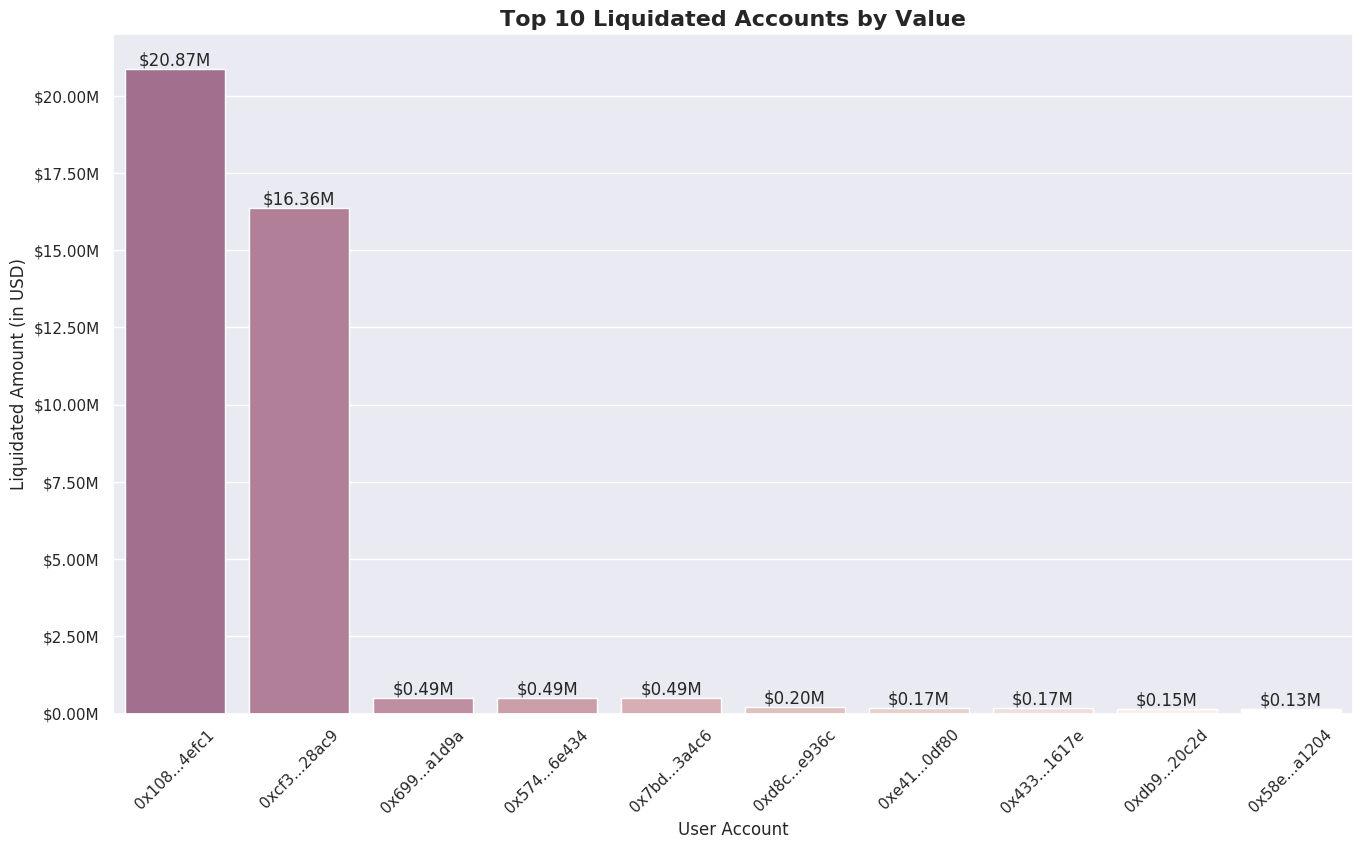

In [31]:
total_liq = df.groupby("user.id")["collateralAmountUsd"].sum().to_frame().sort_values("collateralAmountUsd", ascending=False).iloc[:10].reset_index()

new_names = []

for index, row in total_liq.iterrows():
    new_names.append(row["user.id"][:5] + "..." + row["user.id"][-5:])
    
total_liq["user.id"] = new_names

sns.set_palette(sns.cubehelix_palette(10, dark=0.5, light=1, reverse=True))
cp = sns.barplot(x="user.id", y="collateralAmountUsd", data=total_liq)

ax = cp.axes

yticks = ax.get_yticks()
ax.set_yticklabels(["${:,.2f}M".format(x) for x in yticks/(10**6)])

y_max = total_liq["collateralAmountUsd"].max()
ax.set_ylim([0, roundup_higher(y_max)])

def get_label(y):
    if y <= 10 ** 5:
        return "${:,.1f}k".format(y / (10**3))
    return "${:,.2f}M".format(p.get_height() / (10**6))

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), get_label(p.get_height()),
           fontsize=12, ha='center', va='bottom')
    
ax.set(xlabel="User Account", ylabel="Liquidated Amount (in USD)")

plt.xticks(rotation=45)

plt.title("Top 10 Liquidated Accounts by Value", fontweight="bold", fontsize=16)

plt.show()

In [32]:
total_liquidated = df["collateralAmountUsd"].sum()
top_2_liquidated = total_liq["collateralAmountUsd"].iloc[:2].sum()
top_10_liquidated = total_liq["collateralAmountUsd"].sum()
top_2_percent = (top_2_liquidated / total_liquidated) * 100
top_10_percent = (top_10_liquidated / total_liquidated) * 100

print("{:,.2f}".format(top_2_percent), "{:,.2f}".format(top_10_percent))

89.77 95.31


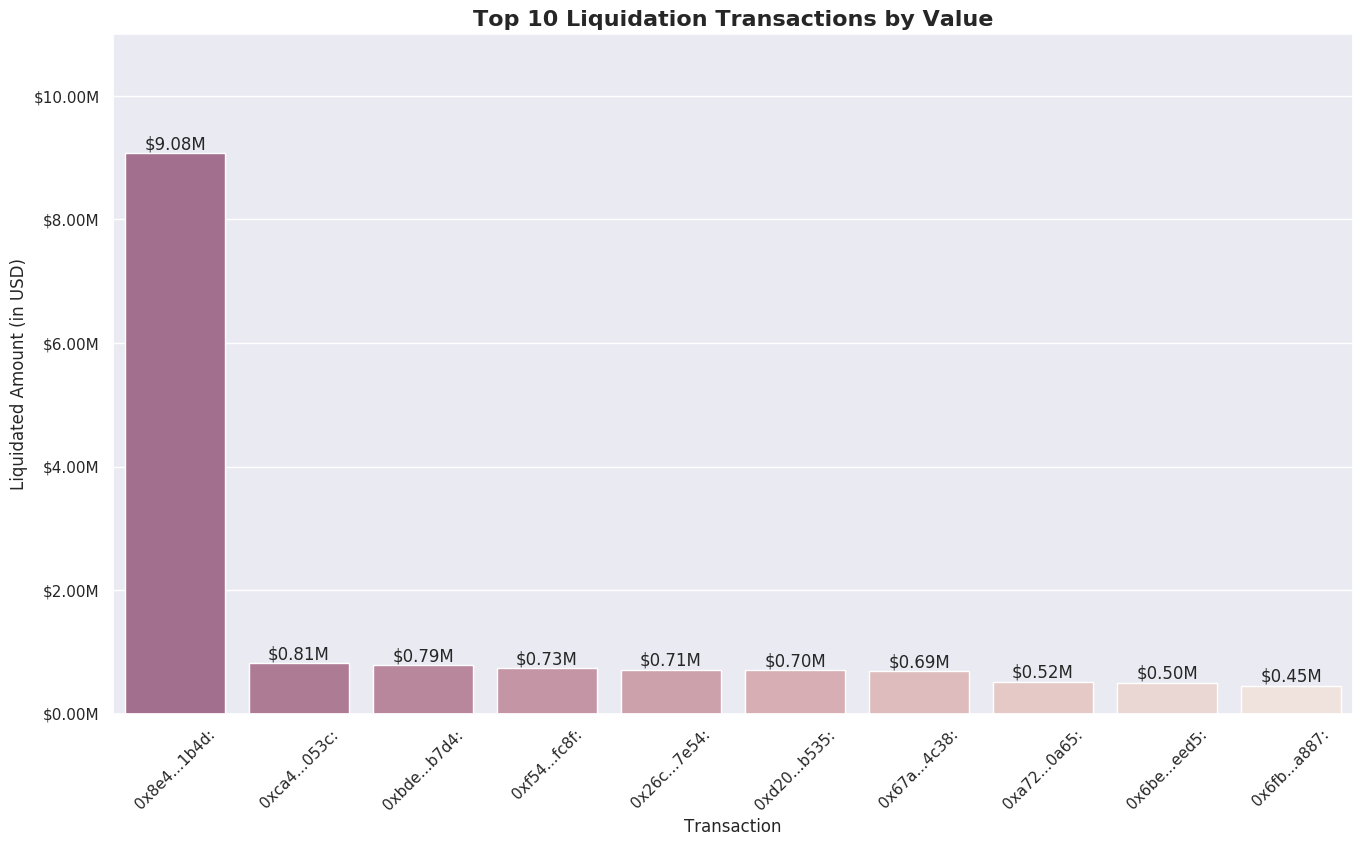

In [35]:
total_liq = df.groupby("id")["collateralAmountUsd"].sum().to_frame().sort_values("collateralAmountUsd", ascending=False).iloc[:10].reset_index()

new_names = []

for index, row in total_liq.iterrows():
    new_names.append(row["id"][:5] + "..." + row["id"][-6:-1])
    
total_liq["id"] = new_names

sns.set_palette(sns.cubehelix_palette(10, dark=0.5, light=0.9, reverse=True))
cp = sns.barplot(x="id", y="collateralAmountUsd", data=total_liq)

ax = cp.axes

yticks = ax.get_yticks()
ax.set_yticklabels(["${:,.2f}M".format(x) for x in yticks/(10**6)])

y_max = total_liq["collateralAmountUsd"].max()
ax.set_ylim([0, roundup_higher(y_max)])

def get_label(y):
    if y <= 10 ** 5:
        return "${:,.1f}k".format(y / (10**3))
    return "${:,.2f}M".format(p.get_height() / (10**6))

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), get_label(p.get_height()),
           fontsize=12, ha='center', va='bottom')
    
ax.set(xlabel="Transaction", ylabel="Liquidated Amount (in USD)")

plt.xticks(rotation=45)

plt.title("Top 10 Liquidation Transactions by Value", fontweight="bold", fontsize=16)

plt.show()

In [39]:
total_liq = df.groupby("id")["collateralAmountUsd"].sum().to_frame().sort_values("collateralAmountUsd", ascending=False).iloc[:10].reset_index()

total_liq["id"].values

array(['0x8e49050106d70b7ffbdf74477edc8195a45590051d53a5138c0d236f616b1b4d:8',
       '0xca4f53ce631297a7e549d309c48f017f6c7b4e115575315f414668e0ebeb053c:8',
       '0xbde5a4f21bd7af20dbe3fc067be66daf58baaaecd30b318e316683778ef7b7d4:8',
       '0xf546000748dc6a4498a7aef6c84a16b22838b832710a16d3cf166bee24b8fc8f:8',
       '0x26cba6d4c5a3f9dfaca7130fa96995af65971addfedab4ae1fd3b414d3ec7e54:8',
       '0xd20d5240c57f60f1393d544e8fcd580b015e308ada5604766f9523b73440b535:8',
       '0x67a0f9dbee4ad7c944677c25aed3aee0c5a877e039c71bb3b1b3387b7b554c38:8',
       '0xa72e5d5fb5177d44acd49dace094670eabd8d6f23121c06cc53f037ea8010a65:8',
       '0x6be7802a85d4521d0783212e7ea2d95fbf5286a24197cbd48a25bf4e20b8eed5:8',
       '0x6fb7d355e441973524483c93b912443bc74ba80f87e3b75a261e2a5f4e6ba887:8'],
      dtype=object)